<a href="https://colab.research.google.com/github/tauisilva/projeto-KDJ/blob/main/Colab/Projeto_KDJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--2023-11-12 21:56:37--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-12 21:56:37--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-11-12 21:56:37--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

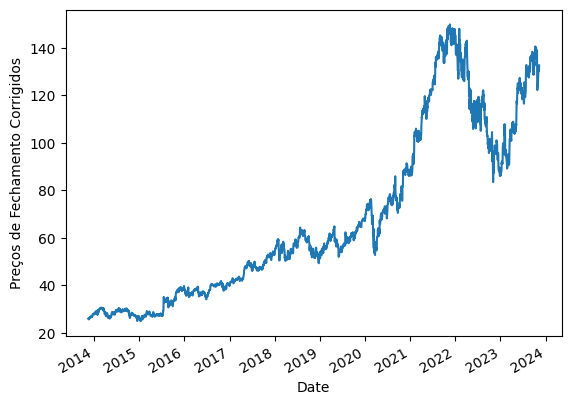

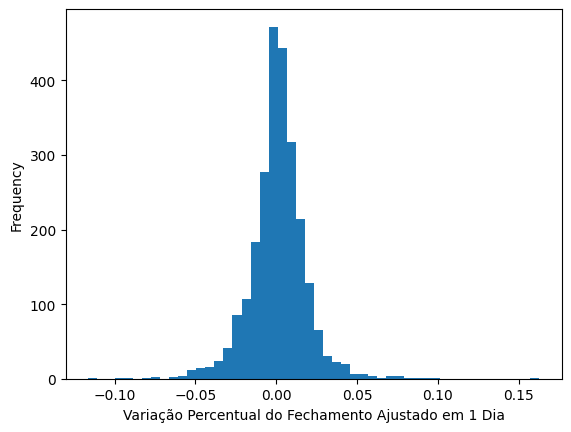




 Melhores parâmetros e pontuação:
{'max_depth': 10, 'max_features': 4, 'n_estimators': 500, 'random_state': 42}
Pontuação: 0.1117




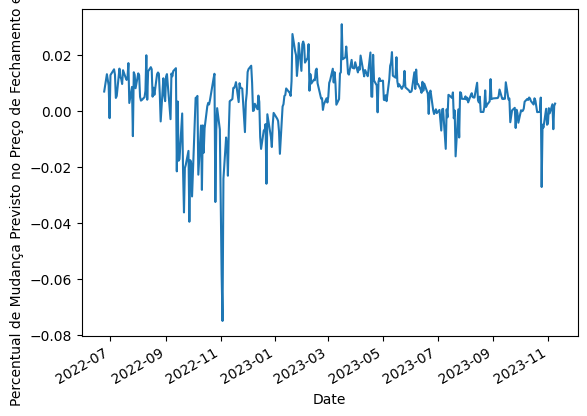

ValueError: ignored

In [5]:
# Instalação do TA-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

# Volte para o diretório raiz
%cd /content

# Imports
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Restante do seu código...


# Configurações
URL_LIBTA_LIB = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
URL_TA_LIB = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'

# Tratamento de Erros
try:
    !curl -L $URL_LIBTA_LIB | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
    !curl -L $URL_TA_LIB | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
except Exception as e:
    print(f"Erro ao baixar e extrair bibliotecas TA-Lib: {e}")

# Gerando intervalos de tempo automaticamente
data_atual = datetime.today().date()
data_atual_10_anos_atras = data_atual - timedelta(days=365 * 10)

codigo_acao = "googl"  # A.K.A "Ticker"
dados_acao_dos_ultimos_10_anos = yf.download(codigo_acao, start=data_atual_10_anos_atras, end=data_atual)

# Exibindo gráfico com os preços de fechamento
dados_acao_dos_ultimos_10_anos['Adj Close'].plot()
plt.ylabel("Preços de Fechamento Corrigidos")
plt.show()

print("\n")

# Calculando a variação percentual entre os dias consecutivos
dados_acao_dos_ultimos_10_anos['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Variação Percentual do Fechamento Ajustado em 1 Dia")
plt.show()

print("\n")

# Calculando indicadores de análise técnica
colunas_dados = []
for n in [21, 50, 80, 200]:
    dados_acao_dos_ultimos_10_anos[f'mma {n}'] = talib.SMA(dados_acao_dos_ultimos_10_anos['Adj Close'].values, timeperiod=n)
    dados_acao_dos_ultimos_10_anos[f'ifr {n}'] = talib.RSI(dados_acao_dos_ultimos_10_anos['Adj Close'].values, timeperiod=n)
    colunas_dados.extend([f'mma {n}', f'ifr {n}'])

# Calculando mudança percentual do volume de negociações
dados_acao_dos_ultimos_10_anos['Volume_1d_change'] = dados_acao_dos_ultimos_10_anos['Volume'].pct_change()
coluna_variacao_de_volume_diario = ['Volume_1d_change']
colunas_dados.extend(coluna_variacao_de_volume_diario)

# Calculando o preço futuro com base nos valores passados
dados_acao_dos_ultimos_10_anos['1d_future_close'] = dados_acao_dos_ultimos_10_anos['Adj Close'].shift(-1)
dados_acao_dos_ultimos_10_anos['1d_close_future_pct'] = dados_acao_dos_ultimos_10_anos['Adj Close'].pct_change(1)

# Removendo valores nulos
dados_acao_dos_ultimos_10_anos.dropna(inplace=True)

# Preparando dados para modelagem
X = dados_acao_dos_ultimos_10_anos[colunas_dados]
y = dados_acao_dos_ultimos_10_anos['1d_close_future_pct']

# Separando dados em conjuntos de treinamento e teste
percentual_total_de_amostras = (85 / 100)
numero_de_amostras = y.shape[0]
tamanho_conjunto_treinamento = int(percentual_total_de_amostras * numero_de_amostras)

X_treino = X[:tamanho_conjunto_treinamento]
y_treino = y[:tamanho_conjunto_treinamento]
X_teste = X[tamanho_conjunto_treinamento:]
y_teste = y[tamanho_conjunto_treinamento:]

# Buscando melhor combinação de hiperparâmetros
parametros_grid_random_forest = {'n_estimators': [500], 'max_depth': [10], 'max_features': [4, 8], 'random_state': [42]}
modelo_random_forest = RandomForestRegressor()
grid_search = GridSearchCV(modelo_random_forest, parametros_grid_random_forest, cv=5)
grid_search.fit(X_treino, y_treino)

# Melhores parâmetros encontrados
melhores_parametros = grid_search.best_params_
melhor_pontuacao = grid_search.best_score_

print("\n Melhores parâmetros e pontuação:")
print(melhores_parametros)
print(f"Pontuação: {melhor_pontuacao:.4f}")
print("\n")

# Treinando modelo com melhores parâmetros
modelo_random_forest = RandomForestRegressor(n_estimators=500, max_depth=10, max_features=8, random_state=42)
modelo_random_forest.fit(X_treino, y_treino)

# Prevendo o preço de fechamento
previsao_preco_fechamento = modelo_random_forest.predict(X_teste)

# Visualizando os dados
serie_previsao_preco_fechamento = pd.Series(previsao_preco_fechamento, index=y_teste.index)
serie_previsao_preco_fechamento.plot()
plt.ylabel("Percentual de Mudança Previsto no Preço de Fechamento em 1 Dia")
plt.show()

print("\n ")

dados_acao_dos_ultimos_10_anos['1d_predicted_close'] = previsao_preco_fechamento

# Visualizando os dados em tabela dos últimos 5 dias de negociação
print(dados_acao_dos_ultimos_10_anos[['Adj Close', '1d_future_close', '1d_predicted_close']].tail())

print("\n ")

# Gráfico comparativo
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_teste.index, y=y_teste, mode='lines', name='Preço Real'))
fig.add_trace(go.Scatter(x=serie_previsao_preco_fechamento.index, y=serie_previsao_preco_fechamento, mode='lines', name='Preço Previsto'))
fig.update_layout(title='Preço Real vs. Preço Previsto',
                  xaxis_title='Data',
                  yaxis_title='Percentual de Mudança Previsto no Preço de Fechamento em 1 Dia')
fig.show()

print("\n ")

# Métricas de erro
erro_medio_absoluto = metrics.mean_absolute_error(y_teste, previsao_preco_fechamento)
erro_medio_quadratico = metrics.mean_squared_error(y_teste, previsao_preco_fechamento)
raiz_erro_medio_quadratico = np.sqrt(erro_medio_quadratico)

print('Erro Médio Absoluto:', erro_medio_absoluto)
print('Erro Médio Quadrático:', erro_medio_quadratico)
print('Raiz do Erro Médio Quadrático:', raiz_erro_medio_quadratico)

print("\n ")

# Importância relativa de cada coluna do modelo
importancia_relativa = modelo_random_forest.feature_importances_
indices_ordenados_importancia = np.argsort(importancia_relativa)[::-1]

valores_importancias = range(len(importancia_relativa))
labels_importancias = np.array(colunas_dados)[indices_ordenados_importancia]

plt.bar(valores_importancias, importancia_relativa[indices_ordenados_importancia], tick_label=labels_importancias)
plt.xticks(rotation=90)
plt.xlabel("Importância relativa de cada indicador utilizado no modelo")
plt.show()